In [1]:
import torch
torch.cuda.is_available()

True

In [15]:
#Make Connection
from databricks.connect import DatabricksSession
import os
token = open("secrets/token").read()
URL = open("secrets/URL").read()
#Explicit configuration
def connect_explicit():
    """Connect with explicit configuration"""
    spark = (DatabricksSession.builder
             .host(URL)
             .token(token)
             .serverless(True)
             .getOrCreate())
    return spark

spark = connect_explicit()

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = spark.read.table("samples.bakehouse.sales_transactions")
display(data)
data = data.toPandas()
data.head()

DataFrame[transactionID: bigint, customerID: bigint, franchiseID: bigint, dateTime: timestamp, product: string, quantity: bigint, unitPrice: bigint, totalPrice: bigint, paymentMethod: string, cardNumber: bigint]

,transactionID,customerID,franchiseID,dateTime,product,quantity,unitPrice,totalPrice,paymentMethod,cardNumber
0,2002961,1000253,3000047,2024-05-14 12:17:01.495952,Golden Gate Ginger,8,3,24,amex,378154478982993
1,2003007,1000226,3000047,2024-05-10 23:10:10.239954,Austin Almond Biscotti,36,3,108,mastercard,2244626981238094
2,2003017,1000108,3000047,2024-05-16 16:34:10.613720,Austin Almond Biscotti,40,3,120,mastercard,2490570234487424
3,2003068,1000173,3000047,2024-05-02 04:31:51.612094,Pearly Pies,28,3,84,amex,343808569426192
4,2003103,1000075,3000047,2024-05-04 23:44:26.902224,Pearly Pies,28,3,84,visa,4377080942201798


<Axes: xlabel='Product', ylabel='Total Price'>

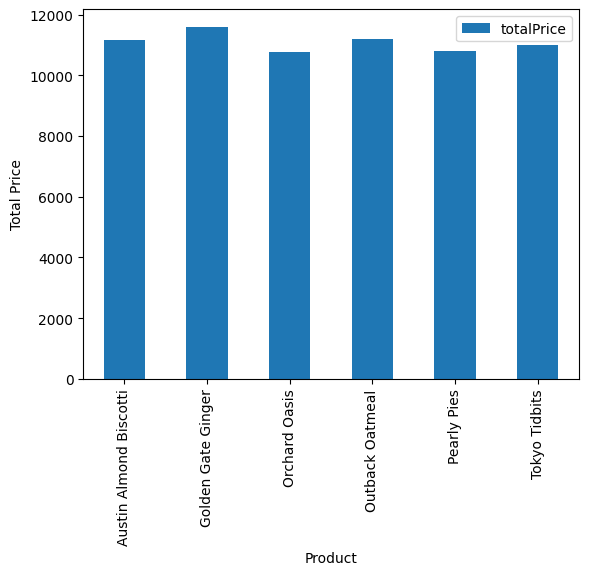

In [6]:
data_grouped = data[["product", "totalPrice"]].groupby("product").sum()
data_grouped.head()
data_grouped.plot.bar(xlabel = "Product", ylabel = "Total Price")

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
qty = np.array(data["quantity"])
qty_tensor = torch.tensor(qty).to(device)
print(qty_tensor)

tensor([ 8, 36, 40,  ...,  4,  8,  8], device='cuda:0')
